In [1]:
import pandas as pd
import numpy as np
from experiments import get_cysec_dataset, split_training_data, train_model, run_experiments, flatten_experiments_results
random_state=1337

# SET Determinism
from os import environ
environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
environ["CUDA_LAUNCH_BLOCKING"] = "1"
import torch
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.benchmark = False

# Disable logging 
import logging
def set_global_logging_level(level=logging.ERROR, prefices=[""]):
    import re
    prefix_re = re.compile(fr'^(?:{ "|".join(prefices) })')
    for name in logging.root.manager.loggerDict:
        if re.match(prefix_re, name):
            logging.getLogger(name).setLevel(level)
set_global_logging_level(logging.CRITICAL) # disable INFO and DEBUG logging everywhere

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = get_cysec_dataset('data/dataset_1.json', random_state=random_state)
data[:3]

,tweetId,userId,text,label,createdAt,displayTextRangeStart,getDisplayTextRangeEnd,label_train,label_bin,label_tri,display_text
0,1202047633398759400,285428413,@noopkat @holtbt MOST FUN DAY EVER HAHAHAH but...,1,{'$date': '2019-12-04T02:11:03Z'},17,148,0,0,0,MOST FUN DAY EVER HAHAHAH but seriously love s...
1,1201870222589939700,15180137,Consider giving to these privacy-focused chari...,2,{'$date': '2019-12-03T14:26:05Z'},0,94,1,1,1,Consider giving to these privacy-focused chari...
2,1207281430637826000,272760181,@zackwhittaker Very brave of your both to shar...,1,{'$date': '2019-12-18T12:48:17Z'},15,85,0,0,0,Very brave of your both to share your story. I...


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_hist(data, title=""):
    sns.histplot(data).set_title(title)
    plt.xticks(np.unique(data))
    plt.show()

def plot_four_hists(data1, data2, data3, data4, title1="", title2="", title3="", title4=""):
    fig, ax =plt.subplots(1,4, figsize=(17,4))
    sns.histplot(data1, ax = ax[0])
    sns.histplot(data2, ax = ax[1])
    sns.histplot(data3, ax = ax[2])
    sns.histplot(data4, ax = ax[3])
    ax[0].legend(labels=[], title=title1)
    ax[1].legend(labels=[], title=title2)
    ax[2].legend(labels=[], title=title3)
    ax[3].legend(labels=[], title=title4)
    ax[0].set_xticks(np.unique(data1))
    ax[1].set_xticks(np.unique(data2))
    ax[2].set_xticks(np.unique(data3))
    ax[3].set_xticks(np.unique(data4))
    fig.tight_layout()
    fig.show()
    
def print_plot(results, title="Experiments"):
    fig, ax =plt.subplots(1,2, figsize=(18,7))
    sns.lineplot(data=results, hue='algorithm', x = "trained_samples" , y = "_accuracy", ci='sd', linewidth=1, ax = ax[0])
#     sns.lineplot(data=results[results.algorithm=='res_rand'], x = "trained_samples" ,y = "_accuracy", ci='sd',  color='orange', linewidth=1, ax = ax[0])
#     sns.lineplot(data=results[results.algorithm=='res_sbert'], x = "trained_samples" ,y = "_accuracy", ci='sd',  color='blue', linewidth=1, ax = ax[0])
#     sns.lineplot(data=results[results.algorithm=='res_bt'], x = "trained_samples" ,y = "_accuracy",  color='green', linewidth=1, ax = ax[0])
    sns.lineplot(data=results, hue='algorithm', x = "trained_samples" , y = "_f1", ci='sd', linewidth=1, ax = ax[1])
#     sns.lineplot(data=results[results.algorithm=='res_rand'], x = "trained_samples" ,y = "_f1",  color='orange', linewidth=1, ax = ax[1])
#     sns.lineplot(data=results[results.algorithm=='res_sbert'], x = "trained_samples" ,y = "_f1",  color='blue', linewidth=1, ax = ax[1])
#     sns.lineplot(data=results[results.algorithm=='res_bt'], x = "trained_samples" ,y = "_f1",  color='green', linewidth=1, ax = ax[1])
    
    ax[0].legend(labels=["Random", "SBERT", "BERTopic"], title = "Accuracy " + title)
    ax[1].legend(labels=["Random", "SBERT", "BERTopic"], title = "F1 " + title)
    fig.show()
# plot_four_hists(data[label_col], y_train, y_val, y_test, title1="Dataset label distribution", title2="Train label distribution", title3="Validation label distribution", title4="Test label distribution")

In [4]:
X_train, y_train, X_test, y_test = split_training_data(data['display_text'], data['label_train'], n_splits=1, random_state=random_state, test_split_ratio=0.4, ) 
X_test, y_test, X_val, y_val = split_training_data(X_test, y_test, n_splits=1, test_split_ratio=0.4, random_state=random_state) 
metrics1, trainer1, model1, tokenizer1 = train_model(X_train, y_train, X_val, y_val, X_test, y_test, random_state=random_state)
metrics2, trainer2, model2, tokenizer2 = train_model(X_train, y_train, X_val, y_val, X_test, y_test, random_state=random_state)
metrics1, metrics2

Some weights of the model checkpoint at ./distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_cl

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.485839,0.812261,0.754170,0.812261,0.773580
2,No log,0.387103,0.858238,0.836809,0.858238,0.835958
3,No log,0.348861,0.865900,0.836768,0.865900,0.849584


***** Running Evaluation *****
  Num examples = 1044
  Batch size = 128
***** Running Evaluation *****
  Num examples = 1044
  Batch size = 128
***** Running Evaluation *****
  Num examples = 1044
  Batch size = 128


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 1566
  Batch size = 128


({'_loss': 0.33466213941574097,
  '_accuracy': 0.8754789272030651,
  '_precision': 0.8844024957501483,
  '_recall': 0.8754789272030651,
  '_f1': 0.863220043474942,
  '_runtime': 1.8756,
  '_samples_per_second': 834.947,
  '_steps_per_second': 6.931,
  'epoch': 3.0},
 {'_loss': 0.33466213941574097,
  '_accuracy': 0.8754789272030651,
  '_precision': 0.8844024957501483,
  '_recall': 0.8754789272030651,
  '_f1': 0.863220043474942,
  '_runtime': 1.768,
  '_samples_per_second': 885.745,
  '_steps_per_second': 7.353,
  'epoch': 3.0})

In [5]:
ex = run_experiments(data, train_col='display_text', label_col='label_train', n_splits=3, sample_size=100, ml_batch_size=50, ml_epochs=3, random_states=[0, 42, 1337], stop_at=500)
ex

Duration: 0:32:39.481296 Duration: 0:00:19.411505 AL:0:00:10.909645 ML:0:00:08.501747


{'res_rand': [[      _loss  _accuracy  _precision   _recall       _f1  _runtime  \
   0  0.888406   0.786207    0.618121  0.786207  0.692105    1.3635   
   1  0.697668   0.786207    0.618121  0.786207  0.692105    1.4170   
   2  0.618326   0.786207    0.618121  0.786207  0.692105    1.3649   
   3  0.557946   0.786207    0.618121  0.786207  0.692105    1.3562   
   4  0.504807   0.807663    0.746636  0.807663  0.769720    1.3625   
   
      _samples_per_second  _steps_per_second  epoch  trained_samples  \
   0              957.128             19.803    3.0              100   
   1              920.959             19.054    3.0              200   
   2              956.138             19.782    3.0              300   
   3              962.240             19.908    3.0              400   
   4              957.779             19.816    3.0              500   
   
                duration_al            duration_ml         duration_total  
   0 0 days 00:00:00.000074 0 days 00:00:08.56

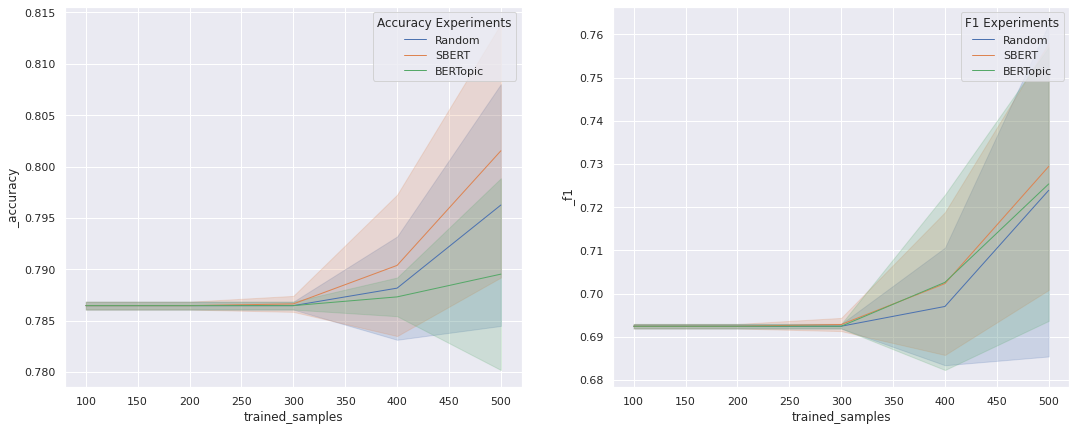

In [6]:
df = pd.DataFrame(flatten_experiments_results(ex))
print_plot(df)